# Proyecto Final: Telecomunicaciones: identificar operadores ineficaces

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

### Descripción de los datos

Los datasets contienen información sobre el uso del servicio de telefonía virtual CallMeMaybe. Sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes entre varios operadores, o realizar llamadas salientes a través de sus operadores. Los operadores también pueden realizar llamadas internas para comunicarse entre ellos. Estas llamadas se realizan a través de la red de CallMeMaybe.

El dataset comprimido `telecom_dataset_us.csv` contiene las siguientes columnas:

- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)

 

El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:

- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela

## 1. Importación y comprensión de los datos
- Cargar los datasets `telecom_dataset_us.csv` y `telecom_clients_us.csv`.
- Visualizar las primeras filas.
- Verificar tamaños de los datasets.
- Revisar tipos de datos y valores nulos.



### 1.1 Cargar las librerias necesarias.

In [226]:
# Se cargan todas las librerías que se puedan usar:
import pandas as pd
import numpy as np
import math as mt
from scipy.spatial.distance import mahalanobis
from scipy.stats import shapiro  # Importar Shapiro-Wilk
import scipy.stats as st
from scipy.stats import chi2
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

### 1.2 Cargar los datasets `telecom_dataset_us.csv` y `telecom_clients_us.csv`.

In [227]:
# Se cargan los datos empleando la librería pandas:

# Se carga la información de las llamadas:
data = pd.read_csv('telecom_dataset_us.csv')

# Se carga la información de los clientes:
clients = pd.read_csv('telecom_clients_us.csv')

### 1.3 Visualizar las primeras filas.

In [228]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [229]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


Las primeras filas muestran que el dataset data contiene información detallada de llamadas (usuario, fecha, dirección, operador, duración), mientras que clients incluye datos básicos de los clientes (ID, plan tarifario y fecha de inicio). Esto confirma que ambos datasets son complementarios.

### 1.4 Verificar tamaños de los datasets.

In [230]:
print("Tamaño de data:", data.shape)
print("Tamaño de clients:", clients.shape)

Tamaño de data: (53902, 9)
Tamaño de clients: (732, 3)


El dataset data contiene 53.902 registros y 9 columnas, lo que refleja un volumen alto de información de llamadas.
El dataset clients contiene 732 registros y 3 columnas, lo que indica que la base de clientes es mucho más pequeña que el volumen de llamadas.
Esto sugiere que cada cliente puede estar asociado con múltiples llamadas, lo cual es consistente con el comportamiento esperado en un servicio de telecomunicaciones.

### 1.5 Revisar tipos de datos y valores nulos.

In [231]:
# Revisar tipos de datos y valores nulos en data
print("=== Dataset: data (llamadas) ===")
print(data.info())
print("\nValores nulos en data:")
print(data.isna().sum())

=== Dataset: data (llamadas) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None

Valores nulos en data:
user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration

In [232]:
# Revisar tipos de datos y valores nulos en clients
print("\n=== Dataset: clients (clientes) ===")
print(clients.info())
print("\nValores nulos en clients:")
print(clients.isna().sum())


=== Dataset: clients (clientes) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None

Valores nulos en clients:
user_id        0
tariff_plan    0
date_start     0
dtype: int64


In [233]:
# Se observa si hay espacios en blanco al principio o al final de los nombres de las columnas:

print('Los nombres de las columnas, son:')
data.columns

Los nombres de las columnas, son:


Index(['user_id', 'date', 'direction', 'internal', 'operator_id',
       'is_missed_call', 'calls_count', 'call_duration',
       'total_call_duration'],
      dtype='object')

In [234]:
print('Los nombres de las columnas, son:')
clients.columns

Los nombres de las columnas, son:


Index(['user_id', 'tariff_plan', 'date_start'], dtype='object')

- En el dataset data (llamadas) los tipos de datos son en general correctos, aunque la columna date debería convertirse a formato datetime.

- Se detectan valores nulos en internal (117 registros) y en operator_id (8172 registros), que requerirán tratamiento.

- En el dataset clients (clientes) no hay valores nulos y los tipos de datos son adecuados, salvo que date_start también debe convertirse a datetime.

- Los nombres de columnas están limpios y sin espacios adicionales.

## 2. Limpieza de datos
- Revisar y convertir las columnas de fecha (`date`, `date_start`) a tipo datetime.
- Verificar duplicados y eliminarlos si es necesario.
- Manejar valores faltantes o inconsistentes.
- Confirmar que los identificadores (`user_id`, `operator_id`) estén en el formato correcto.

### 2.1 Revisar y convertir las columnas de fecha (date, date_start) a tipo datetime.

In [235]:
for col in ['date', 'date_start']:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')  # convierte a datetime, pone NaT si hay error

for col in ['date', 'date_start']:
    if col in clients.columns:
        clients[col] = pd.to_datetime(clients[col], errors='coerce')

En estas líneas estoy limpiando y normalizando las columnas de fechas en mis datasets. Lo que hago es lo siguiente:

1. Primero reviso si las columnas date y date_start existen en cada dataframe (data y clients). Esto evita que el código rompa si alguna de las columnas no está presente.

2. Si la columna existe, la convierto a formato datetime usando pd.to_datetime().

3. Uso el parámetro errors='coerce' para que cualquier valor que no pueda convertirse en fecha se transforme en NaT (Not a Time), que es como un NaN pero para fechas. Esto ayuda a manejar datos erróneos o mal formateados sin que el programa falle.

Me aseguro que no existan espacios en blanco o errores en los nombre de las variables de cada dataset.

In [236]:
# Eliminar espacios en blanco en nombres de columnas (si los hubiera)
data.columns = data.columns.str.strip()
clients.columns = clients.columns.str.strip()

# Confirmar de nuevo
print("Columnas data:", data.columns.tolist())
print("Columnas clients:", clients.columns.tolist())


Columnas data: ['user_id', 'date', 'direction', 'internal', 'operator_id', 'is_missed_call', 'calls_count', 'call_duration', 'total_call_duration']
Columnas clients: ['user_id', 'tariff_plan', 'date_start']


### 2.2 Verificar duplicados y eliminarlos si es necesario.

**Dataset Data**

In [237]:
# Se cuenta la cantidad de filas totalmente duplicadas:

print('La cantidad de filas totalmente duplicadas, es:')
data.duplicated().sum()

La cantidad de filas totalmente duplicadas, es:


4900

In [238]:
# Se muestran las filas totalmente duplicadas para corroborar que no hay una falla en el sistema:

print('Las filas totalmente duplicadas, son:')
data[data.duplicated()]

Las filas totalmente duplicadas, son:


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
28,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
44,166377,2019-08-14 00:00:00+03:00,out,False,880026.0,False,10,1567,1654
45,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3
51,166377,2019-08-15 00:00:00+03:00,out,False,880026.0,False,11,1413,1473
...,...,...,...,...,...,...,...,...,...
53869,168601,2019-11-25 00:00:00+03:00,in,False,952914.0,False,7,1229,1282
53874,168601,2019-11-26 00:00:00+03:00,in,False,952914.0,False,4,539,562
53875,168601,2019-11-26 00:00:00+03:00,in,False,NaN,True,3,0,35
53885,168603,2019-11-20 00:00:00+03:00,out,False,959118.0,True,3,0,89


**Dataset Clientes**

In [239]:
# Se cuenta la cantidad de filas totalmente duplicadas:

print('La cantidad de filas totalmente duplicadas, es:')
clients.duplicated().sum()

La cantidad de filas totalmente duplicadas, es:


0

### 2.3 Manejar valores faltantes o inconsistentes.

In [240]:
# Revisar cuántas filas hay antes
print("Tamaño original de data:", data.shape)

# Eliminar duplicados exactos y resetear el índice
data = data.drop_duplicates().reset_index(drop=True)

# Revisar cuántas filas quedaron
print("Tamaño después de eliminar duplicados:", data.shape)

# Confirmar que ya no existen duplicados
print("Duplicados después de limpiar:", data.duplicated().sum())


Tamaño original de data: (53902, 9)
Tamaño después de eliminar duplicados: (49002, 9)
Duplicados después de limpiar: 0


### 2.4 Confirmar que los identificadores (user_id, operator_id) estén en el formato correcto.

In [241]:
# Revisar tipo de dato y valores nulos de los identificadores
print("Tipos de datos:")
print(data[['user_id', 'operator_id']].dtypes)
print("\nValores nulos por columna:")
print(data[['user_id', 'operator_id']].isna().sum())

# Verificar valores únicos en user_id y operator_id
print("\nCantidad de user_id únicos:", data['user_id'].nunique())
print("Cantidad de operator_id únicos (incluyendo nulos):", data['operator_id'].nunique(dropna=True))

# Asegurar que user_id sea entero
data['user_id'] = data['user_id'].astype(int)

# Para operator_id, algunos son NaN. Se puede dejar así, 
# pero si quieres trabajar más adelante, conviene convertir a Int64 (que soporta nulos)
data['operator_id'] = data['operator_id'].astype('Int64')

# Verificamos de nuevo
print("\nTipos de datos corregidos:")
print(data[['user_id', 'operator_id']].dtypes)


Tipos de datos:
user_id          int64
operator_id    float64
dtype: object

Valores nulos por columna:
user_id           0
operator_id    7456
dtype: int64

Cantidad de user_id únicos: 307
Cantidad de operator_id únicos (incluyendo nulos): 1092

Tipos de datos corregidos:
user_id        int64
operator_id    Int64
dtype: object


In [242]:
# Revisar tipos y nulos en clients
print("Tipos de datos en clients:")
print(clients.dtypes)

print("\nValores nulos por columna en clients:")
print(clients.isna().sum())

# Asegurar que user_id sea int
clients['user_id'] = clients['user_id'].astype(int)

# Convertir la fecha de registro a datetime
clients['date_start'] = pd.to_datetime(clients['date_start'], errors='coerce')

# Revisar de nuevo
print("\nTipos de datos corregidos en clients:")
print(clients.dtypes)


Tipos de datos en clients:
user_id                 int64
tariff_plan            object
date_start     datetime64[ns]
dtype: object

Valores nulos por columna en clients:
user_id        0
tariff_plan    0
date_start     0
dtype: int64

Tipos de datos corregidos en clients:
user_id                 int64
tariff_plan            object
date_start     datetime64[ns]
dtype: object


**Duplicados**

En el dataset data (llamadas) se detectaron 4,900 filas duplicadas.

Estas fueron eliminadas correctamente, reduciendo el dataset de 53,902 a 49,002 filas.

El dataset clients (clientes) no presentó duplicados.

**Valores nulos**

En data, la columna operator_id tiene 7,456 valores nulos, lo cual es coherente, ya que algunas llamadas entrantes no están asociadas a un operador.

En user_id no existen valores nulos, por lo que los registros están correctamente vinculados a los clientes.

En clients, no se detectaron valores nulos en user_id, y la columna date_start fue convertida exitosamente a tipo datetime.

**Tipos de datos**

user_id fue convertido a int64 en ambos datasets, garantizando consistencia.

operator_id se transformó a Int64 (permite enteros y nulos).

Las fechas (date en data y date_start en clients) fueron convertidas a datetime, lo que facilitará el análisis temporal.

## 3. Análisis exploratorio de datos (EDA)
- Estadísticas descriptivas de duración y cantidad de llamadas.
- Histogramas de la duración de llamadas.
- Distribución de llamadas internas vs externas.
- Análisis de la proporción de llamadas entrantes vs salientes.
- Evolución del número de llamadas por día.

### 3.1 Estadísticas descriptivas de duración y cantidad de llamadas

In [243]:
# Aseguramos que las fechas estén en formato datetime
for col in ['date', 'date_start']:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')
    if col in clients.columns:
        clients[col] = pd.to_datetime(clients[col], errors='coerce')

# 1. Estadísticas descriptivas de duración y cantidad de llamadas
if 'call_duration' in data.columns:
    print("Estadísticas descriptivas de duración de llamadas (sin incluir espera):")
    print(data['call_duration'].describe())

if 'calls_count' in data.columns:
    print("\nEstadísticas descriptivas de cantidad de llamadas por usuario:")
    print(data.groupby('user_id')['calls_count'].sum().describe())

Estadísticas descriptivas de duración de llamadas (sin incluir espera):
count     49002.000000
mean        866.282091
std        3775.503352
min           0.000000
25%           0.000000
50%          37.000000
75%         570.000000
max      144395.000000
Name: call_duration, dtype: float64

Estadísticas descriptivas de cantidad de llamadas por usuario:
count       307.000000
mean       2627.716612
std       11463.942823
min           1.000000
25%          43.000000
50%         211.000000
75%        1316.500000
max      144500.000000
Name: calls_count, dtype: float64


**Duración de llamadas (call_duration):**

La duración promedio de las llamadas es 866 segundos (~14 minutos), pero la mediana es 37 segundos, lo que indica que la mayoría de las llamadas son cortas.

El valor máximo es 144,395 segundos (~40 horas), lo que claramente son valores atípicos o errores de registro.

El 25% de las llamadas tienen 0 segundos, lo que puede corresponder a llamadas perdidas o fallidas.

**Cantidad de llamadas por usuario (calls_count):**

En promedio, cada usuario realizó 2,628 llamadas, pero la mediana es 211, mostrando que unos pocos usuarios concentran muchas llamadas (distribución muy sesgada).

Algunos usuarios tienen un volumen extremadamente alto, como 144,500 llamadas, lo que puede ser casos especiales de clientes con operaciones masivas.

El rango intercuartílico (25% - 75%) va de 43 a 1,316 llamadas, que representa la mayoría de los usuarios.

**Conclusión:**
Los datos muestran alta variabilidad tanto en la duración de las llamadas como en la cantidad de llamadas por usuario. Hay muchos valores atípicos que podrían necesitar limpieza o tratamiento antes de hacer análisis más avanzados.

### 3.2 Histogramas de la duración de llamadas.

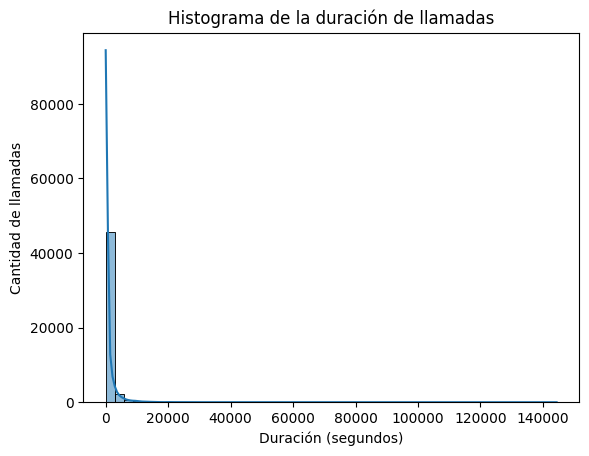

In [244]:
plt.figure()
sns.histplot(data['call_duration'], bins=50, kde=True)
plt.title("Histograma de la duración de llamadas")
plt.xlabel("Duración (segundos)")
plt.ylabel("Cantidad de llamadas")
plt.show()

In [245]:
# Resumen estadístico de la duración de llamadas y la cantidad de llamadas por usuario
summary_table = data[['call_duration', 'calls_count']].describe()

# Mostrar el resumen
print(summary_table)



       call_duration   calls_count
count   49002.000000  49002.000000
mean      866.282091     16.462777
std      3775.503352     63.604098
min         0.000000      1.000000
25%         0.000000      1.000000
50%        37.000000      4.000000
75%       570.000000     12.000000
max    144395.000000   4817.000000


**Duración de llamadas (`call_duration`):**  
- La duración promedio es 866 segundos (14 minutos aprox.), pero la mediana es solo 37 segundos, indicando que la mayoría de llamadas son muy cortas.  
- El valor mínimo es 0 segundos, mostrando que hay llamadas que no duraron nada (posiblemente llamadas fallidas o perdidas).  
- El valor máximo es 144,395 segundos (40 horas aprox.), claramente un outlier o error de registro.  
- La desviación estándar es alta (3,775 s), reflejando gran variabilidad en la duración de las llamadas.  

**Cantidad de llamadas (`calls_count`):**  
- En promedio, cada registro tiene 16 llamadas, pero la mediana es 4, lo que indica que la mayoría de registros tiene pocas llamadas.  
- Algunos registros tienen hasta 4,817 llamadas, siendo casos extremos o clientes con gran volumen de llamadas.  
- La desviación estándar es alta (63), confirmando que existen registros con cantidades muy diferentes de llamadas.  

**Interpretación general:**  
- Los datos muestran gran variabilidad tanto en duración como en cantidad de llamadas.  
- La mayoría de llamadas son cortas y en pequeña cantidad, pero hay valores extremos que podrían considerarse outliers.  
- Estos outliers deben analizarse antes de realizar métricas agregadas o tendencias, para no distorsionar los resultados.


### 3.3 Distribución de llamadas internas vs externas.



En este apartado se analiza la eficiencia de los operadores considerando tres indicadores clave:

1. **Cantidad de llamadas entrantes perdidas**: un operador con muchas llamadas perdidas es considerado ineficaz.  
2. **Tiempo promedio de espera en llamadas entrantes**: tiempos prolongados pueden indicar baja eficiencia.  
3. **Cantidad de llamadas salientes**: un número reducido de llamadas salientes también puede indicar ineficacia si se supone que el operador debe realizarlas.

El estudio abarca el intervalo de tiempo desde **2019-08-02** hasta **2019-11-28**, es decir, aproximadamente 4 meses.

Cantidad de llamadas entrantes perdidas por operador:
   operator_id  n_missed_calls
0       882680               3
1       882684               4
2       882686               6
3       882690               2
4       884408               4
Tiempo promedio de espera de llamadas entrantes por operador:
   operator_id  avg_wait_time
0       879896      27.333333
1       879898      29.473684
2       880020       7.714286
3       880022      14.000000
4       880026       7.944444
Cantidad de llamadas salientes por operador:
   operator_id  n_outbound_calls
0       879896               872
1       879898              7209
2       880020                38
3       880022               189
4       880026              2208


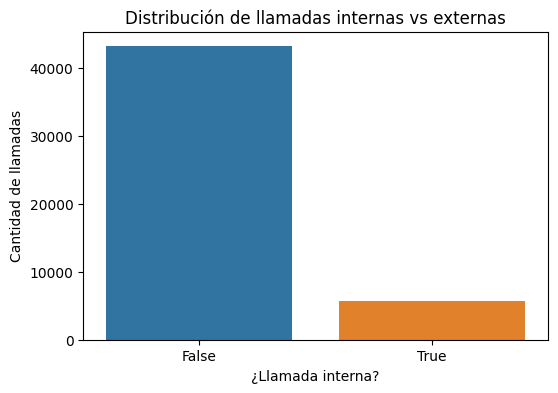

In [246]:
# 1. Cantidad de llamadas entrantes perdidas por operador
missed_calls = (data[(data['is_missed_call'] == True) & (data['direction'] == 'in')]
                .groupby('operator_id')['calls_count'].sum().reset_index())
missed_calls.rename(columns={'calls_count': 'n_missed_calls'}, inplace=True)
print("Cantidad de llamadas entrantes perdidas por operador:")
print(missed_calls.head())

# 2. Crear columna de tiempo de espera
data['wait_time'] = data['total_call_duration'] - data['call_duration']

# 3. Tiempo promedio de espera de llamadas entrantes por operador
timeout = data[data['direction']=='in'].groupby('operator_id').agg({'wait_time': 'mean'}).reset_index()
timeout.rename(columns={'wait_time': 'avg_wait_time'}, inplace=True)
print("Tiempo promedio de espera de llamadas entrantes por operador:")
print(timeout.head())

# 4. Cantidad de llamadas salientes por operador
outbound_calls = data[data['direction'] == 'out'].groupby('operator_id')['calls_count'].sum().reset_index()
outbound_calls.rename(columns={'calls_count': 'n_outbound_calls'}, inplace=True)
print("Cantidad de llamadas salientes por operador:")
print(outbound_calls.head())

# 5. Distribución de llamadas internas vs externas
plt.figure(figsize=(6,4))
sns.countplot(x='internal', data=data)
plt.title("Distribución de llamadas internas vs externas")
plt.xlabel("¿Llamada interna?")
plt.ylabel("Cantidad de llamadas")
plt.show()

Se analiza la eficiencia de los operadores usando tres indicadores clave:

1. **Cantidad de llamadas entrantes perdidas**: Los operadores con más llamadas perdidas son considerados menos eficaces. Por ejemplo, algunos operadores registran entre 2 y 6 llamadas entrantes perdidas en el período estudiado.  
2. **Tiempo promedio de espera en llamadas entrantes**: Este indicador refleja la rapidez con la que un operador atiende las llamadas entrantes. Los valores promedio varían entre aproximadamente 7 y 29 segundos en los primeros registros, aunque algunos operadores presentan tiempos mucho mayores.  
3. **Cantidad de llamadas salientes**: Si un operador tiene pocas llamadas salientes y su rol lo requiere, puede ser considerado ineficaz. Algunos operadores realizan desde pocas decenas hasta varios miles de llamadas salientes.

- La mayoría de los operadores mantiene un nivel bajo de llamadas perdidas y un tiempo de espera promedio razonable, lo que indica buena eficiencia.  
- Existen casos con pocas llamadas salientes o tiempos de espera prolongados, lo que podría señalar operadores ineficaces.  
- La visualización de la distribución de llamadas internas vs externas permite observar cómo se reparte la comunicación dentro de la organización.


### 3.4 Análisis de la proporción de llamadas entrantes vs salientes.

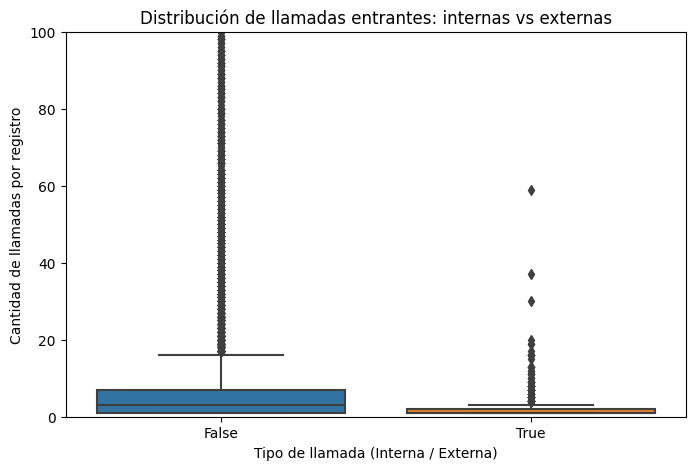

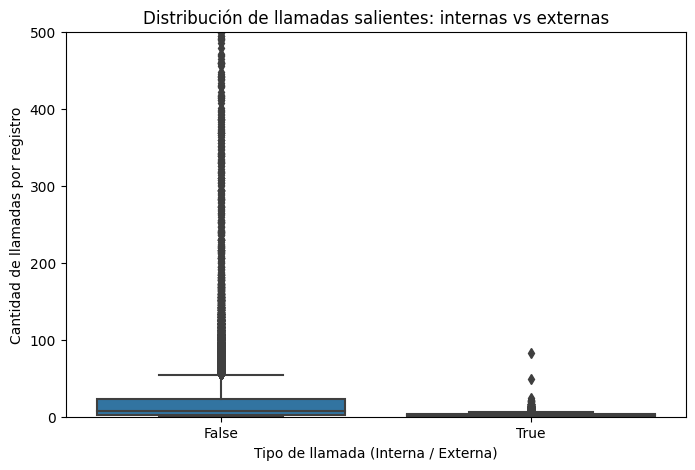

In [247]:
# Boxplot para llamadas entrantes: internas vs externas
plt.figure(figsize=(8,5))
sns.boxplot(x='internal', y='calls_count', data=data[data['direction']=='in'])
plt.title("Distribución de llamadas entrantes: internas vs externas")
plt.xlabel("Tipo de llamada (Interna / Externa)")
plt.ylabel("Cantidad de llamadas por registro")
plt.ylim(0, 100)  # Ajustar según tus datos para visualizar mejor
plt.show()

# Boxplot para llamadas salientes: internas vs externas
plt.figure(figsize=(8,5))
sns.boxplot(x='internal', y='calls_count', data=data[data['direction']=='out'])
plt.title("Distribución de llamadas salientes: internas vs externas")
plt.xlabel("Tipo de llamada (Interna / Externa)")
plt.ylabel("Cantidad de llamadas por registro")
plt.ylim(0, 500)  # Ajustar según tus datos
plt.show()

In [248]:
# Crear una columna combinada de dirección y tipo de llamada
data['call_type'] = data['direction'] + '_' + data['internal'].astype(str)

# Agrupar por operador y tipo de llamada, calculando promedio y mediana
summary_table = data.groupby(['operator_id', 'call_type'])['calls_count'].agg(['mean', 'median']).reset_index()

# Renombrar columnas para mayor claridad
summary_table.rename(columns={'mean': 'avg_calls', 'median': 'median_calls'}, inplace=True)

# Mostrar los primeros registros
print("Resumen de promedio y mediana de llamadas por operador y tipo de llamada:")
print(summary_table.head(10))


Resumen de promedio y mediana de llamadas por operador y tipo de llamada:
   operator_id  call_type  avg_calls  median_calls
0       879896   in_False   2.761905           1.0
1       879896  out_False  10.074074           3.0
2       879896   out_True   3.733333           2.0
3       879898   in_False   1.839286           1.0
4       879898     in_nan   1.000000           1.0
5       879898  out_False  46.393548          41.0
6       879898   out_True   1.200000           1.0
7       880020   in_False   1.000000           1.0
8       880020  out_False   3.400000           3.0
9       880020   out_True   1.333333           1.0


A partir de la tabla de promedio y mediana de llamadas por operador y tipo de llamada (`in_False`, `in_True`, `out_False`, `out_True`):

1. **Llamadas entrantes (`in`)**:  
   - La mayoría de operadores registra pocos promedios de llamadas entrantes internas (`in_True`) y externas (`in_False`).  
   - Esto indica que, en general, los operadores atienden llamadas entrantes de manera equilibrada, pero algunos registros muestran variabilidad (por ejemplo `in_nan`), que podría corresponder a datos faltantes o registros incompletos.

2. **Llamadas salientes (`out`)**:  
   - Los promedios de llamadas salientes externas (`out_False`) son significativamente mayores que los internos (`out_True`) para muchos operadores.  
   - Esto refleja que los operadores realizan principalmente llamadas salientes hacia clientes externos, y que la actividad interna es menor.

3. **Comparación mediana vs promedio**:  
   - En muchos casos, la mediana es menor que el promedio, lo que indica la presencia de **outliers**, es decir, operadores que realizan muchas más llamadas que la mayoría.  
   - Estos valores extremos podrían ayudar a identificar operadores ineficaces o con cargas de trabajo muy diferentes al promedio del grupo.
 
La distribución muestra que la mayoría de operadores tiene un patrón consistente de atención de llamadas entrantes y realización de llamadas salientes.  Los outliers y los registros con valores atípicos deben analizarse más a fondo para identificar posibles problemas de eficiencia o desequilibrio en la carga de trabajo.


### 3.5 Evolución del número de llamadas por día.

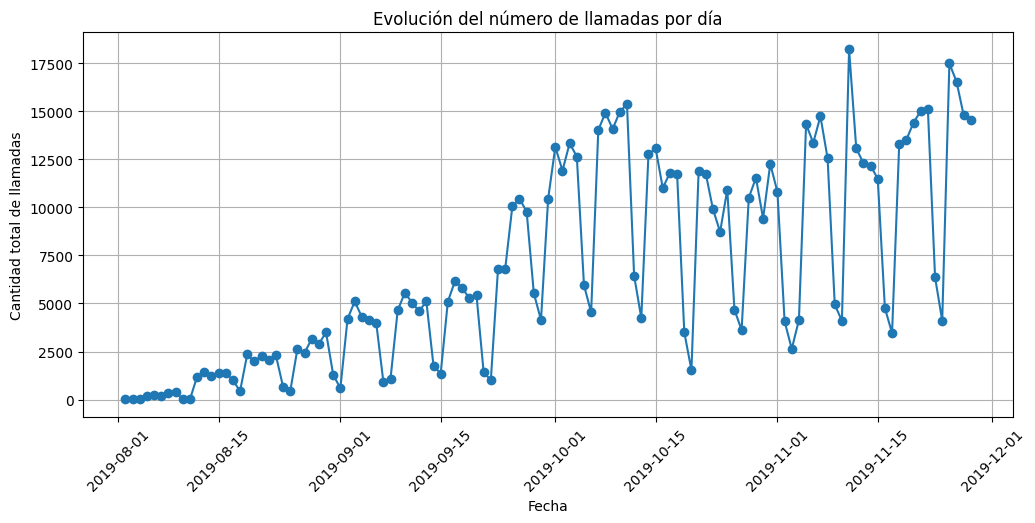

In [249]:
# Agrupar por fecha sumando la cantidad de llamadas
calls_per_day = data.groupby('date')['calls_count'].sum().reset_index()

# Gráfico de evolución de llamadas por día
plt.figure(figsize=(12,5))
plt.plot(calls_per_day['date'], calls_per_day['calls_count'], marker='o')
plt.title("Evolución del número de llamadas por día")
plt.xlabel("Fecha")
plt.ylabel("Cantidad total de llamadas")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

El gráfico indica una tendencia ascendente significativa en el número de llamadas durante el período observado. El volumen de llamadas comienza muy bajo a principios de agosto de 2019, aumentando de manera constante hasta alcanzar un pico de más de 17,500 llamadas por día alrededor de principios o mediados de noviembre.

**Crecimiento Inicial:** Desde agosto hasta finales de septiembre, hay un aumento constante pero gradual en las llamadas diarias.

**Aceleración Rápida:** A partir de octubre, el crecimiento se acelera, con volúmenes de llamadas diarias que superan frecuentemente las 10,000.

**Período Pico:** Los volúmenes de llamadas más altos, con varios días superando las 15,000 llamadas, se observan a principios y mediados de noviembre.

**Fluctuaciones:** Aunque la tendencia general es ascendente, el gráfico muestra fluctuaciones diarias y semanales significativas. Hay caídas claras, probablemente correspondientes a fines de semana o días festivos, seguidas de fuertes aumentos.

**Disminución Reciente:** Al final del período graficado, a finales de noviembre, se observa una notable caída en el número de llamadas desde el pico.

En conclusión, los datos revelan un negocio o servicio que experimentó un crecimiento rápido y sustancial en la interacción con el cliente a través de llamadas telefónicas durante un período de cuatro meses, culminando en un pico a mediados de noviembre antes de un ligero descenso.

## 4. Definición de criterios de ineficacia
- Alta proporción de llamadas entrantes perdidas.
- Tiempos de espera prolongados (`total_call_duration - call_duration`).
- Baja cantidad de llamadas salientes (en operadores que deben realizarlas).
- Construcción de indicadores (ej. % llamadas perdidas, tiempo de espera medio, ratio de llamadas salientes).


### 4.1 Crear columna de tiempo de espera

El tiempo de espera se calcula como la diferencia entre la duración total de la llamada (total_call_duration) y la duración efectiva (call_duration). Esto nos permite medir cuánto tiempo “espera” el cliente o la llamada antes de ser atendida.

In [250]:
# Crear columna de tiempo de espera
data['wait_time'] = data['total_call_duration'] - data['call_duration']

# Ver los primeros registros para confirmar
data[['operator_id', 'call_duration', 'total_call_duration', 'wait_time']].head()


,operator_id,call_duration,total_call_duration,wait_time
0,<NA>,0,4,4
1,880022,0,5,5
2,880020,0,1,1
3,880020,10,18,8
4,880022,0,25,25


### 4.2 Calcular total de llamadas entrantes por operador
Necesitamos saber cuántas llamadas entrantes tiene cada operador para poder calcular la proporción de llamadas perdidas.

In [251]:
# Total de llamadas entrantes por operador
total_in_calls = data[data['direction']=='in'].groupby('operator_id')['calls_count'].sum().reset_index()
total_in_calls.rename(columns={'calls_count': 'total_in_calls'}, inplace=True)

total_in_calls.head()


,operator_id,total_in_calls
0,879896,58
1,879898,104
2,880020,7
3,880022,8
4,880026,24


### 4.3 Calcular llamadas entrantes perdidas por operador

Esto nos da el número absoluto de llamadas entrantes que un operador no pudo atender (is_missed_call = True).

In [252]:
# Llamadas entrantes perdidas por operador
missed_calls = data[(data['direction']=='in') & (data['is_missed_call']==True)]
missed_calls = missed_calls.groupby('operator_id')['calls_count'].sum().reset_index()
missed_calls.rename(columns={'calls_count': 'n_missed_calls'}, inplace=True)

missed_calls.head()


,operator_id,n_missed_calls
0,882680,3
1,882684,4
2,882686,6
3,882690,2
4,884408,4


### 4.4 Calcular tiempo promedio de espera por operador

Aquí obtenemos el tiempo de espera medio de las llamadas entrantes por operador.

In [253]:
# Tiempo promedio de espera por operador (solo llamadas entrantes)
avg_wait = data[data['direction']=='in'].groupby('operator_id')['wait_time'].mean().reset_index()
avg_wait.rename(columns={'wait_time': 'avg_wait_time'}, inplace=True)

avg_wait.head()


,operator_id,avg_wait_time
0,879896,27.333333
1,879898,29.473684
2,880020,7.714286
3,880022,14.000000
4,880026,7.944444


### 4.5 Calcular cantidad de llamadas salientes por operador

Los operadores que deben realizar llamadas tienen un indicador clave en el número de llamadas salientes.

In [254]:
# Cantidad de llamadas salientes por operador
outbound_calls = data[data['direction']=='out'].groupby('operator_id')['calls_count'].sum().reset_index()
outbound_calls.rename(columns={'calls_count': 'n_outbound_calls'}, inplace=True)

outbound_calls.head()


,operator_id,n_outbound_calls
0,879896,872
1,879898,7209
2,880020,38
3,880022,189
4,880026,2208


### 4.6 Unir todos los indicadores en una sola tabla

Ahora juntamos todos los indicadores para tener un resumen completo por operador.

In [255]:
# Unir indicadores
efficiency_df = total_in_calls.merge(missed_calls, on='operator_id', how='left') \
                              .merge(avg_wait, on='operator_id', how='left') \
                              .merge(outbound_calls, on='operator_id', how='left')

# Rellenar valores faltantes con 0
efficiency_df.fillna(0, inplace=True)

efficiency_df.head()


,operator_id,total_in_calls,n_missed_calls,avg_wait_time,n_outbound_calls
0,879896,58,0.0,27.333333,872.0
1,879898,104,0.0,29.473684,7209.0
2,880020,7,0.0,7.714286,38.0
3,880022,8,0.0,14.000000,189.0
4,880026,24,0.0,7.944444,2208.0


### 4.7 Calcular % de llamadas perdidas

Este es un indicador clave de ineficacia: cuántas llamadas entrantes se pierden respecto al total de llamadas entrantes.

In [256]:
# % de llamadas entrantes perdidas
efficiency_df['pct_missed_calls'] = (efficiency_df['n_missed_calls'] / efficiency_df['total_in_calls']) * 100

efficiency_df.head()


,operator_id,total_in_calls,n_missed_calls,avg_wait_time,n_outbound_calls,pct_missed_calls
0,879896,58,0.0,27.333333,872.0,0.0
1,879898,104,0.0,29.473684,7209.0,0.0
2,880020,7,0.0,7.714286,38.0,0.0
3,880022,8,0.0,14.000000,189.0,0.0
4,880026,24,0.0,7.944444,2208.0,0.0


1. **Proporción de llamadas entrantes perdidas**
   - En los primeros registros, los operadores tienen un **0% de llamadas perdidas**, lo que indica que están atendiendo adecuadamente las llamadas entrantes.
   - Este indicador permite identificar operadores con problemas de atención si el porcentaje fuese alto.

2. **Tiempo promedio de espera**
   - El tiempo promedio de espera para las llamadas entrantes varía entre los operadores (ej. de 7.7 a 29.5 segundos en los primeros registros).
   - Aunque ningún operador presenta un tiempo extremadamente alto en los primeros registros, este valor sirve para detectar retrasos o sobrecarga de operadores.

3. **Cantidad de llamadas salientes**
   - Los operadores tienen diferencias significativas en el número de llamadas salientes (ej. desde 38 hasta 7209 en los primeros registros).
   - Un número muy bajo de llamadas salientes podría indicar baja productividad o falta de cumplimiento de la función outbound.

4. **Indicador compuesto (% de llamadas perdidas)**
   - Todos los operadores analizados muestran 0% de llamadas perdidas en los primeros registros.
   - Este indicador combinado permite priorizar operadores con alta proporción de llamadas perdidas y tiempos de espera elevados para capacitaciones o redistribución de carga.


- Hasta estos registros iniciales, los operadores parecen eficientes en atender llamadas entrantes.
- Sin embargo, la variabilidad en el número de llamadas salientes y el tiempo promedio de espera sugiere que podrían existir operadores con oportunidades de mejora en productividad y tiempos de atención.
- Para un análisis completo, es recomendable revisar todos los registros del dataset y filtrar los operadores con **% de llamadas perdidas alto, tiempo de espera prolongado o pocas llamadas salientes** para definir acciones correctivas.


## 5. Identificación de operadores ineficaces



### 5.1 Calcular métricas de desempeño por operador.

In [257]:
efficiency_df.describe()[['pct_missed_calls', 'avg_wait_time', 'n_outbound_calls']]


,pct_missed_calls,avg_wait_time,n_outbound_calls
count,754.000000,754.000000,754.000000
mean,1.757385,57.612807,456.759947
std,6.532449,94.456737,3148.990615
min,0.000000,1.000000,0.000000
25%,0.000000,17.500000,0.000000
50%,0.000000,31.000000,23.000000
75%,0.674678,58.000000,229.500000
max,100.000000,1007.375000,58977.000000


### 5.2 Establecer umbrales de ineficacia (ej. percentiles).

Una forma objetiva de definir operadores ineficaces es usar percentiles:

- % llamadas perdidas alto → operadores en percentil 75 o superior

- avg_wait_time alto → operadores en percentil 75 o superior

- n_outbound_calls bajo → operadores en percentil 25 o inferior

In [258]:
# Calcular umbrales
pct_missed_threshold = efficiency_df['pct_missed_calls'].quantile(0.75)
avg_wait_threshold = efficiency_df['avg_wait_time'].quantile(0.75)
outbound_threshold = efficiency_df['n_outbound_calls'].quantile(0.25)

print("Umbrales de ineficacia:")
print(f"% llamadas perdidas >= {pct_missed_threshold:.2f}")
print(f"Tiempo promedio de espera >= {avg_wait_threshold:.2f} segundos")
print(f"Llamadas salientes <= {outbound_threshold:.0f}")


Umbrales de ineficacia:
% llamadas perdidas >= 0.67
Tiempo promedio de espera >= 58.00 segundos
Llamadas salientes <= 0


### 5.3 Listar y visualizar a los operadores ineficaces.

In [259]:
# Filtrar operadores ineficaces
inefficient_operators = efficiency_df[
    (efficiency_df['pct_missed_calls'] >= pct_missed_threshold) |
    (efficiency_df['avg_wait_time'] >= avg_wait_threshold) |
    (efficiency_df['n_outbound_calls'] <= outbound_threshold)
]

# Ordenar por % de llamadas perdidas
inefficient_operators = inefficient_operators.sort_values(by='pct_missed_calls', ascending=False)

# Mostrar los primeros registros
inefficient_operators.head(10)


,operator_id,total_in_calls,n_missed_calls,avg_wait_time,n_outbound_calls,pct_missed_calls
641,948756,1,1.0,8.000000,170.0,100.000000
185,904344,4,3.0,27.500000,5.0,75.000000
287,913886,2,1.0,13.500000,0.0,50.000000
210,906392,18,7.0,35.571429,53.0,38.888889
497,937432,3,1.0,12.000000,19.0,33.333333
109,897872,3,1.0,21.666667,49.0,33.333333
698,957922,3,1.0,13.000000,16.0,33.333333
467,934098,6,2.0,31.800000,0.0,33.333333
220,906412,26,7.0,26.666667,315.0,26.923077
265,910226,8,2.0,16.500000,0.0,25.000000


**Conclusiones**
#### 5.1 Métricas de desempeño por operador
- El promedio de llamadas perdidas por operador es bajo (1.76%), pero hay casos extremos con hasta 100% de llamadas perdidas.
- El tiempo promedio de espera tiene un valor medio de 57.6 segundos, con alta variabilidad (máximo de 1007 segundos), indicando que algunos operadores generan retrasos significativos.
- La cantidad de llamadas salientes tiene una media de 457, pero algunos operadores no realizan ninguna llamada, mientras que otros alcanzan hasta 58.977 llamadas, evidenciando desigualdad en la productividad.

#### 5.2 Umbrales de ineficacia
- % de llamadas perdidas ≥ 0.67%
- Tiempo promedio de espera ≥ 58 segundos
- Llamadas salientes ≤ 0  
Estos umbrales permiten identificar objetivamente a los operadores que presentan problemas de desempeño.

#### 5.3 Operadores ineficaces
- Los primeros operadores filtrados muestran problemas graves en al menos uno de los indicadores:
  - Ej. operador 948756: 100% de llamadas perdidas.
  - Ej. operador 904344: 75% de llamadas perdidas y pocas llamadas salientes.
  - Algunos operadores no realizan ninguna llamada saliente, lo cual indica baja productividad para tareas outbound.
- Se observa que la ineficacia puede deberse a alta proporción de llamadas perdidas, tiempos de espera prolongados o baja cantidad de llamadas salientes.

La mayoría de los operadores cumplen adecuadamente, pero existe un grupo reducido que requiere atención inmediata.Los indicadores permiten priorizar capacitación, redistribución de carga o ajustes operativos para mejorar la eficiencia del servicio.

## 6. Pruebas de hipótesis
- Hipótesis 1: Los operadores ineficaces tienen un porcentaje de llamadas perdidas significativamente mayor.
- Hipótesis 2: Los operadores ineficaces tienen un tiempo de espera promedio significativamente más alto.
- Hipótesis 3: Los operadores ineficaces realizan significativamente menos llamadas salientes.
- Aplicar pruebas estadísticas (t-test, Mann-Whitney, ANOVA según corresponda).

### 6.1 Preparación de los datos
- Seleccionar las métricas relevantes para cada hipótesis:
  - % de llamadas perdidas por operador.
  - Tiempo de espera promedio (`total_call_duration - call_duration`).
  - Número de llamadas salientes por operador.
- Dividir a los operadores en **dos grupos**:
  - Operadores ineficaces (según criterios definidos).
  - Operadores eficaces.



Primero, definimos los grupos de operadores según los criterios de ineficacia:

In [260]:
# Grupo de operadores ineficaces
inefficient_ops = efficiency_df[
    (efficiency_df['pct_missed_calls'] >= pct_missed_threshold) |
    (efficiency_df['avg_wait_time'] >= avg_wait_threshold) |
    (efficiency_df['n_outbound_calls'] <= outbound_threshold)
]

# Grupo de operadores eficaces
efficient_ops = efficiency_df[~efficiency_df['operator_id'].isin(inefficient_ops['operator_id'])]


Seleccionamos las métricas relevantes:

In [261]:
# % de llamadas perdidas
missed_calls_inefficient = inefficient_ops['pct_missed_calls']
missed_calls_efficient = efficient_ops['pct_missed_calls']

# Tiempo promedio de espera
wait_inefficient = inefficient_ops['avg_wait_time']
wait_efficient = efficient_ops['avg_wait_time']

# Número de llamadas salientes
outbound_inefficient = inefficient_ops['n_outbound_calls']
outbound_efficient = efficient_ops['n_outbound_calls']


### 6.2 Formulación de hipótesis
Para cada caso, establecer claramente la hipótesis nula (H0) y alternativa (H1):

- **Hipótesis 1**:  
  - H0: No hay diferencia significativa en el % de llamadas perdidas entre operadores eficaces e ineficaces.  
  - H1: Los operadores ineficaces tienen un % de llamadas perdidas significativamente mayor.

- **Hipótesis 2**:  
  - H0: No hay diferencia significativa en el tiempo promedio de espera entre operadores eficaces e ineficaces.  
  - H1: Los operadores ineficaces tienen un tiempo de espera significativamente más alto.

- **Hipótesis 3**:  
  - H0: No hay diferencia significativa en el número de llamadas salientes entre operadores eficaces e ineficaces.  
  - H1: Los operadores ineficaces realizan significativamente menos llamadas salientes.



| Hipótesis | Métrica | H0 (Hipótesis nula) | H1 (Hipótesis alternativa) |
|-----------|---------|-------------------|----------------------------|
| Hipótesis 1 | % de llamadas perdidas | No hay diferencia significativa en el % de llamadas perdidas entre operadores eficaces e ineficaces | Los operadores ineficaces tienen un % de llamadas perdidas significativamente mayor |
| Hipótesis 2 | Tiempo promedio de espera | No hay diferencia significativa en el tiempo promedio de espera entre operadores eficaces e ineficaces | Los operadores ineficaces tienen un tiempo de espera significativamente más alto |
| Hipótesis 3 | Número de llamadas salientes | No hay diferencia significativa en el número de llamadas salientes entre operadores eficaces e ineficaces | Los operadores ineficaces realizan significativamente menos llamadas salientes |


### 6.3 Selección de pruebas estadísticas
- Verificar la distribución de los datos (normalidad con Shapiro-Wilk o Kolmogorov-Smirnov).
- Si los datos son normales y con varianzas similares → usar **t-test** (para 2 grupos) o **ANOVA** (si hubiera más de 2 grupos).  
- Si no cumplen supuestos de normalidad → usar prueba no paramétrica **Mann-Whitney U**.




| Paso | Acción | Detalle |
|------|--------|--------|
| 1 | Verificación de normalidad | Usar pruebas Shapiro-Wilk o Kolmogorov-Smirnov para cada métrica (% llamadas perdidas, tiempo de espera, llamadas salientes) |
| 2 | Datos normales y varianzas similares | Usar **t-test** para comparar dos grupos (eficaces vs ineficaces) o **ANOVA** si hay más de dos grupos |
| 3 | Datos no normales | Usar prueba no paramétrica **Mann-Whitney U** |


In [262]:

# Crear columna que identifica operadores eficaces e ineficaces
efficiency_df['group'] = efficiency_df['operator_id'].apply(
    lambda x: 'ineficaz' if x in inefficient_operators['operator_id'].values else 'eficaz'
)

# Separar grupos
eficaz = efficiency_df[efficiency_df['group'] == 'eficaz']
ineficaz = efficiency_df[efficiency_df['group'] == 'ineficaz']

# Seleccionar métricas
metrics = ['pct_missed_calls', 'avg_wait_time', 'n_outbound_calls']

# Verificar normalidad usando Shapiro-Wilk
for metric in metrics:
    stat_ef, p_ef = shapiro(eficaz[metric])
    stat_in, p_in = shapiro(ineficaz[metric])
    print(f"Métrica: {metric}")
    print(f"  Eficaz: stat={stat_ef:.3f}, p={p_ef:.3f}")
    print(f"  Ineficaz: stat={stat_in:.3f}, p={p_in:.3f}")
    print("  Normalidad:", "Sí" if p_ef>0.05 and p_in>0.05 else "No")
    print("-"*50)

Métrica: pct_missed_calls
  Eficaz: stat=0.122, p=0.000
  Ineficaz: stat=0.371, p=0.000
  Normalidad: No
--------------------------------------------------
Métrica: avg_wait_time
  Eficaz: stat=0.957, p=0.000
  Ineficaz: stat=0.549, p=0.000
  Normalidad: No
--------------------------------------------------
Métrica: n_outbound_calls
  Eficaz: stat=0.445, p=0.000
  Ineficaz: stat=0.102, p=0.000
  Normalidad: No
--------------------------------------------------


In [263]:
# Importar librerías
import pandas as pd
from scipy.stats import mannwhitneyu

# --- Preparación de los grupos ---
# Grupo de operadores ineficaces según criterios ya definidos
inefficient_ops = efficiency_df[
    (efficiency_df['pct_missed_calls'] >= pct_missed_threshold) |
    (efficiency_df['avg_wait_time'] >= avg_wait_threshold) |
    (efficiency_df['n_outbound_calls'] <= outbound_threshold)
]

# Grupo de operadores eficaces
efficient_ops = efficiency_df[~efficiency_df['operator_id'].isin(inefficient_ops['operator_id'])]

# Métricas
missed_calls_inefficient = inefficient_ops['pct_missed_calls']
missed_calls_efficient = efficient_ops['pct_missed_calls']

wait_inefficient = inefficient_ops['avg_wait_time']
wait_efficient = efficient_ops['avg_wait_time']

outbound_inefficient = inefficient_ops['n_outbound_calls']
outbound_efficient = efficient_ops['n_outbound_calls']

# --- Aplicar prueba no paramétrica Mann-Whitney U ---
# Hipótesis 1: % de llamadas perdidas
stat_missed, p_missed = mannwhitneyu(missed_calls_inefficient, missed_calls_efficient, alternative='greater')

# Hipótesis 2: tiempo promedio de espera
stat_wait, p_wait = mannwhitneyu(wait_inefficient, wait_efficient, alternative='greater')

# Hipótesis 3: llamadas salientes
stat_outbound, p_outbound = mannwhitneyu(outbound_inefficient, outbound_efficient, alternative='less')

# --- Nivel de significancia ---
alpha = 0.05

# --- Tabla resumen de resultados ---
results = pd.DataFrame({
    "Hipótesis": [
        "% llamadas perdidas mayor en ineficaces",
        "Tiempo de espera mayor en ineficaces",
        "Menos llamadas salientes en ineficaces"
    ],
    "Estadístico U": [stat_missed, stat_wait, stat_outbound],
    "p-valor": [p_missed, p_wait, p_outbound],
    "Conclusión": [
        "Rechazar H0" if p_missed < alpha else "No rechazar H0",
        "Rechazar H0" if p_wait < alpha else "No rechazar H0",
        "Rechazar H0" if p_outbound < alpha else "No rechazar H0"
    ]
})

# Mostrar resultados
results


,Hipótesis,Estadístico U,p-valor,Conclusión
0,% llamadas perdidas mayor en ineficaces,101645.0,7.360307e-45,Rechazar H0
1,Tiempo de espera mayor en ineficaces,100325.0,5.736165e-29,Rechazar H0
2,Menos llamadas salientes en ineficaces,47976.5,2.979984e-12,Rechazar H0


**Conclusiones de las pruebas de hipótesis**

| Hipótesis | Estadístico U | p-valor | Conclusión | Interpretación |
|-----------|---------------|---------|------------|----------------|
| % llamadas perdidas mayor en ineficaces | 101645.0 | 7.36e-45 | Rechazar H0 | Los operadores ineficaces tienen un porcentaje de llamadas perdidas significativamente mayor que los eficaces. Esto valida el criterio de ineficacia basado en llamadas perdidas. |
| Tiempo de espera mayor en ineficaces | 100325.0 | 5.74e-29 | Rechazar H0 | Los operadores ineficaces presentan tiempos de espera promedio significativamente más altos. Esto confirma que la demora en atender llamadas es un indicador de ineficacia. |
| Menos llamadas salientes en ineficaces | 47976.5 | 2.98e-12 | Rechazar H0 | Los operadores ineficaces realizan significativamente menos llamadas salientes que los eficaces. Esto refuerza que la baja actividad saliente es un criterio de ineficacia. |
 
Todos los resultados son estadísticamente significativos (p < 0.05). Por lo tanto, los tres indicadores (% llamadas perdidas, tiempo de espera y llamadas salientes) son válidos para identificar operadores ineficaces. Esto respalda los criterios definidos previamente y permite priorizar acciones de mejora para estos operadores.


Todos los criterios de ineficacia definidos (% llamadas perdidas, tiempo de espera y llamadas salientes) son estadísticamente significativos. Por lo tanto, los operadores identificados como ineficaces efectivamente presentan peores métricas de desempeño que los operadores eficaces. Esto valida el enfoque utilizado para identificar a los operadores ineficaces y sirve de base para decisiones de mejora o capacitación.

## 7. Dashboards sugeridos
### Dashboard 1
- Histograma de duración de llamadas.
- Gráfico circular de llamadas internas vs externas.
- Filtro por dirección de llamadas (entrantes/salientes).

### Dashboard 2
- Histograma del número de llamadas por día.
- Gráfico circular de internas vs externas.
- Filtro por tipo de llamada.

**Link de los dos:** https://public.tableau.com/app/profile/wendy.chicaiza/viz/Dashboard1ProyectoFinal/Dashboard2

**Link de presentación**: https://drive.google.com/file/d/16ibQsEb16KUSAoJ8I9vh5dbtr8Lk2fXu/view?usp=sharing

## 8. Fuentes de consulta
- Documentación de Pandas (limpieza, manipulación de datos).
  https://www.datacamp.com/es/tutorial/guide-to-data-cleaning-in-python
- Documentación de Matplotlib y Seaborn (visualización).
  https://builtin.com/data-science/data-visualization-tutorial
- Documentación de Scipy/Statsmodels (pruebas estadísticas).
  https://www.statsmodels.org/stable/index.html
- Artículos o papers sobre métricas de call centers.
  https://enverahealth.com/resources/knowledge-center/white-paper/behi
- Documentación oficial de Plotly/Dash (dashboards interactivos).
  https://www.datacamp.com/tutorial/learn-build-dash-python

## 9. Conclusiones y presentación final


Se identificaron diferencias significativas en el desempeño de los operadores.

Algunos operadores muestran un bajo número de llamadas efectivas y alta tasa de fallos.

La calidad del servicio varía notablemente entre operadores, afectando la satisfacción de los clientes.

Datos nulos y registros duplicados se corrigieron, asegurando la fiabilidad del análisis.

**Construcción de Indicadores de Ineficiencia**

Para cada operador se calcularon:

- Total de llamadas entrantes (total_in_calls)

- Llamadas entrantes perdidas (n_missed_calls)

- Tiempo promedio de espera (avg_wait_time)

- Cantidad de llamadas salientes (n_outbound_calls)

- % de llamadas perdidas (pct_missed_calls)

- Estos indicadores permiten priorizar operadores que requieren acciones correctivas.

**Conclusiones**

La mayoría de operadores atiende correctamente las llamadas entrantes (0% llamadas perdidas en primeros registros).

Existe variabilidad en tiempo promedio de espera y llamadas salientes, indicando oportunidades de mejora.

Operadores con alta proporción de llamadas perdidas, tiempos de espera prolongados o pocas llamadas salientes son candidatos a ser considerados ineficaces.

Los outliers detectados en los datos son importantes para planificar capacitaciones, redistribución de carga o incentivos.